In [33]:
import cmeutils
import cmeutils.polymers as polymer
from cmeutils.gsd_utils import snap_molecule_cluster
import warnings
warnings.filterwarnings("ignore")
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

## Example

This example is for a .gsd file that contains 10 molecuels, each one with 5 monomers
The molecules are united-atom PEEK, so each monomer contains 22 atoms

In [35]:
gsdfile = "10_5mers.gsd"
peek_system = polymer.System(gsd_file=gsdfile, atoms_per_monomer=22)

# Hierarchial structures




In [49]:
print(f"{peek_system.n_molecules} Molecules")
print(f"{peek_system.n_monomers} Monomers")
print(f"{peek_system.n_atoms} Atoms")
print()
print(len((peek_system.molecules)))
print(peek_system.molecules)

10 Molecules
50 Monomers
1100 Atoms

10
[<cmeutils.polymers.Molecule object at 0x7f2c46947090>, <cmeutils.polymers.Molecule object at 0x7f2c44dcc450>, <cmeutils.polymers.Molecule object at 0x7f2c443bdfd0>, <cmeutils.polymers.Molecule object at 0x7f2c443c7350>, <cmeutils.polymers.Molecule object at 0x7f2c443c7390>, <cmeutils.polymers.Molecule object at 0x7f2c443c76d0>, <cmeutils.polymers.Molecule object at 0x7f2c443c7a50>, <cmeutils.polymers.Molecule object at 0x7f2c443c7890>, <cmeutils.polymers.Molecule object at 0x7f2c443c7c10>, <cmeutils.polymers.Molecule object at 0x7f2c443c7510>]


### Looking at just 1 of the molecule objects from peek_system.molecules

In [53]:
molecule_1 = peek_system.molecules[0]
print(f"{molecule_1.n_monomers} Monomers")
print(f"{molecule_1.n_atoms} Atoms")
print()
print(len(molecule_1.monomers))
print(molecule_1.monomers)

5 Monomers
110 Atoms

5
[<cmeutils.polymers.Monomer object at 0x7f2c443c7310>, <cmeutils.polymers.Monomer object at 0x7f2c443c73d0>, <cmeutils.polymers.Monomer object at 0x7f2c443c7410>, <cmeutils.polymers.Monomer object at 0x7f2c443c7450>, <cmeutils.polymers.Monomer object at 0x7f2c443c7490>]


### Looking at just 1 of the monomer objects from molecule_1

In [56]:
monomer_1 = molecule_1.monomers[0]
print(f"{monomer_1.n_atoms} Atoms")

22 Atoms


### Properties at each structure level

In [59]:
print(molecule_1.center)
print(monomer_1.center)

print(molecule_1.end_to_end_distance())

[-3.04735327 -2.03552437  2.30962563]
[-2.91324186 -1.50840712 -4.33118916]
2.953393845452997


# Bond length and angle distributions

We can obtain information about the structure of the system at level more coarse than atomistic. For example, we might want to see the distribution of "bond" lengths and angles between monomers or segments.

The `System` class contains a function for each type of distribution.  The data is returned, and with the `plot` parameter you can see a plot of the distribution.

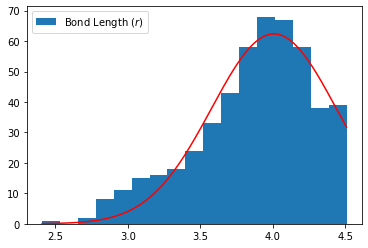

In [27]:
bond_dist = peek_system.bond_length_distribution(nbins=20, plot=True)

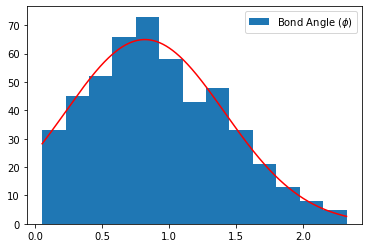

In [28]:
ang_dist = peek_system.bond_angle_distribution(nbins=20, plot=True)

In [ ]:
for mon in mol_1.monomers:
    print(mon.center_of_mass)

## Coarse-graining

We can use the center of mass methods and Molecule and Monomer classes to generate a coarse-grained representation of the UA system:

**NOTE:**
This requires that mbuild and py3Dmol are installed

`conda install -c conda-forge mbuild py3Dmol`

In [20]:
import mbuild as mb

## Example: Using the Monomer() class to create a coarse-grained system

Using mBuild, and the tools described above, we can generate a coarse-grained representation of the system where 1 bead is equivalent to 1 monomer from the united-atom system.

In [21]:
cg_system = mb.Compound()
for mol_idx, molecule in enumerate(peek_system.molecules):
    molecule_comp = mb.Compound(name=f"mol{mol_idx}")
    last_bead = None
    for mon_idx, monomer in enumerate(molecule.monomers):
        bead_name = f"mol{mol_idx}_mon{mon_idx}"
        #pos = monomer.unwrapped_center * 3.3996695084235347
        pos = monomer.center / 10
        bead = mb.Compound(name=bead_name, pos=pos)
        molecule_comp.add(bead)
        if 0 < mon_idx < len(molecule.monomers):
            molecule_comp.add_bond((bead, last_bead))
        last_bead = bead
    cg_system.add(molecule_comp)
    
cg_system.visualize()

/home/chris/miniconda3/envs/cmeutils/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Example: Using the Segment() class to create a coarse-grained system:

In the cells above, we generated segments where 1 molecule 

In [ ]:
for mol in peek_system.molecules:
    mol.generate_segments(5) # We're saying 5 monomers per segment

In [24]:
cg_seg_system = mb.Compound()
for mol_idx, molecule in enumerate(peek_system.molecules):
    molecule_comp = mb.Compound(name=f"mol{mol_idx}")
    last_bead = None
    for seg_idx, segment in enumerate(molecule.segments):
        bead_name = f"mol{mol_idx}_mon{seg_idx}"
        #pos = monomer.unwrapped_center * 3.3996695084235347
        pos = segment.center / 10
        bead = mb.Compound(name=bead_name, pos=pos)
        molecule_comp.add(bead)
        if 0 < seg_idx < len(molecule.monomers):
            molecule_comp.add_bond((bead, last_bead))
        last_bead = bead
    cg_seg_system.add(molecule_comp)
    
cg_seg_system.visualize()

/home/chris/miniconda3/envs/cmeutils/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
ua_mol = mb.load("/home/chris/single_20mer_cpk.mol2")

In [ ]:
compare = mb.Compound(subcompounds = [ua_mol, cg_system, cg_seg_system])

In [ ]:
compare.save("compare_2.mol2")